In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
from pathlib import Path
import sys
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
ROOT_PATH = Path().resolve().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
DIR_PATH = Path().resolve()
from frequency_response import FrequencyResponse
from biquad import digital_coeffs, peaking

## Create Data

In [49]:
# Read equalization curves from results as data
# TODO: Create data generator for unlimited data
data_path =  DIR_PATH.joinpath('data.npy')
if data_path.is_file():
    # Saved previously to numpy file
    data = np.load(data_path)
else:
    # Not saved, read frequency response CSVs
    data = []
    for fp in ROOT_PATH.joinpath('results').glob('**/*.csv'):
        fr = FrequencyResponse.read_from_csv(fp)
        fr.interpolate()
        data.append(fr.equalization)
    data = np.vstack(data)
    np.save(data_path, data)

#data /= 40

# Split data into training and testing
n_train = int(len(data) * 0.8)
n_test = len(data) - n_train
train = data[:n_train]
test = data[n_train:]

## Parametric Equalizer Frequency Response

In [16]:
def peq_fr(filters):
    # Calculate frequency response from the predicted parameters
    # Parametric equalizers use biquad filters for which frequency response can be calculated from zero-pole presentation
    # Calculate a and b coefficients first
    # https://en.wikipedia.org/wiki/Digital_biquad_filter
    # Index ranges are necessary to prevent Tensors from being squeezed
    A = 10 ** (filters[:, :, 2:3] / 40)  # Gain at index 2
    # Power 10 for center frequency forcing optimizer to produce linear values between ~1~5
    # Optimizer cannot handle logarithmic variables
    w0 = 2 * np.pi * filters[:, :, 0:1] / fs # Fc at index 0
    alpha = tf.sin(w0) / (2 * filters[:, :, 1:2])  # Q at index 1

    a0 = 1 + alpha / A
    a1 = -(-2 * tf.cos(w0)) / a0
    a2 = -(1 - alpha / A) / a0

    b0 = (1 + alpha * A) / a0
    b1 = (-2 * tf.cos(w0)) / a0
    b2 = (1 - alpha * A) / a0
    
    f = tf.constant(np.repeat(np.expand_dims(frequency, axis=0), filters.shape[0], axis=0), name='f', dtype='float32')
    w = 2 * np.pi * f / fs
    phi = 4 * tf.sin(w / 2) ** 2
    
    a0 = 1.0  # Normalized form
    a1 *= -1
    a2 *= -1
    
    # Equalizer frequency response from a and b coefficients
    eq_fr = 10 * tf.math.log(
        (b0 + b1 + b2) ** 2 + (b0 * b2 * phi - (b1 * (b0 + b2) + 4 * b0 * b2)) * phi
    ) / tf.math.log(10.0) - 10 * tf.math.log(
        (a0 + a1 + a2) ** 2 + (a0 * a2 * phi - (a1 * (a0 + a2) + 4 * a0 * a2)) * phi
    ) / tf.math.log(10.0)  # TF has not log10
    # Total equalizer frequency response is the sum of all filters' frequency responses
    return tf.reduce_sum(eq_fr, axis=1)

## Model

In [47]:
n_filters = 10
hidden_size = 16
lr = 0.0001  # TODO: Find suitable learning rate for fast convergence
fs = 46010.0  # For both 44.1 and 48 kHz

inputs = keras.Input(shape=data.shape[1])  # Input layer, take size data
x = layers.Dense(hidden_size, activation='relu')(inputs)  # First hidden layer
outputs = layers.Dense(n_filters * 3)(x)  # Output layer: 10 filters with 3 parameters each
model = keras.Model(inputs=inputs, outputs=outputs, name='peq')
frequency = FrequencyResponse(name='f').frequency.copy()
f = tf.constant(np.repeat(np.expand_dims(frequency, axis=0), n_filters, axis=0), name='f', dtype='float32')

def loss(eq_fr_target, eq_parameters):
    """Loss function. Calculates frequency response of a parametric equalizer which has N filters with Fc, Q and gain given as eq_parameters
    
    Args:
        eq_target: Target vector for the equalizer frequency response
        eq_parameters: Predicted parametric eq parameters as 3*N dimensional vector with N 3 parameter groups
        
    Returns:
        Loss value
    """
    # Reshape rank 1 Tensor of eq parameters to rank 2 Tensor with shape Nx3
    # First 3 items in the input eq parameters are Fc, Q and gain of the first filter, next 3 are Fc, Q and gain of the second filters and so on
    filters = tf.reshape(eq_parameters, (tf.size(eq_parameters) / (n_filters * 3), n_filters, 3))  # Each row contains Fc, Q and gain
    filters = tf.stack([
        tf.pow(10.0, filters[:, :, 0]),
        filters[:, :, 1],
        filters[:, :, 2]
    ], axis=2)
    
    # MSE as loss
    # Equalizer frequency response should be zero
    l = tf.reduce_mean(tf.square(peq_fr(filters) - eq_fr_target))
    # Penalize for having gain > +-12 dB
    #l += filter[:, :, tf.abs(filter[:, :, 2]) > 12] * maaginen_l
    return l


def scheduler(epoch, current_lr):
    if epoch < 12:
        return lr / (12 - epoch)
    else:
        return current_lr * 0.98

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
model.compile(loss=loss, optimizer=keras.optimizers.Adam())


def predict(eq_fr_target):
    filters = model.predict(eq_fr_target)
    filters = np.reshape(filters, (filters.size // (n_filters * 3), n_filters, 3))
    filters[:, :, 0] = 10 ** filters[:, :, 0]
    return filters

In [50]:
# TODO: It would be better to generate data between epochs?
history = model.fit(
    train, train,
    #train[:10], train[:10],
    batch_size=10,  # TODO: Adjust batch size for better performance, bigger batch size runs faster
    epochs=100,  # TODO: Adjust this
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/100


TypeError: in user code:

    C:\Users\jaakko\code\AutoEq\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-37-733911ef704f>:36 loss  *
        l = tf.reduce_mean(tf.square(peq_fr(filters) - eq_fr_target))
    <ipython-input-16-f9b38c035b12>:21 peq_fr  *
        f = tf.constant(np.repeat(np.expand_dims(frequency, axis=0), filters.shape[0], axis=0), name='f', dtype='float32')
    <__array_function__ internals>:5 repeat  **
        
    C:\Users\jaakko\code\AutoEq\venv\lib\site-packages\numpy\core\fromnumeric.py:479 repeat
        return _wrapfunc(a, 'repeat', repeats, axis=axis)
    C:\Users\jaakko\code\AutoEq\venv\lib\site-packages\numpy\core\fromnumeric.py:67 _wrapfunc
        return _wrapit(obj, method, *args, **kwds)
    C:\Users\jaakko\code\AutoEq\venv\lib\site-packages\numpy\core\fromnumeric.py:44 _wrapit
        result = getattr(asarray(obj), method)(*args, **kwds)

    TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'


## Debug

[[[ 1.7336007e+03  1.9287045e+00  5.6809485e-01]
  [ 1.4641916e+02  5.0733882e-01  7.9013184e-02]
  [ 2.5439560e-02 -1.2437638e+00 -5.1999016e+00]
  [ 1.3065974e+05  9.0712982e-01 -1.8798090e+00]
  [ 3.0119217e+01 -3.1056297e-01  1.7575746e+00]
  [ 7.1359140e-01  3.2152951e-02 -6.0139847e-01]
  [ 3.6688254e+02 -2.2020917e+00  4.9170084e+00]
  [ 5.0372913e+01  1.2461951e+00  1.1799419e+00]
  [ 8.6905397e-02 -2.3338454e+00 -1.8424561e+00]
  [ 9.8488507e+02  3.1008894e+00 -3.7314892e+00]]]


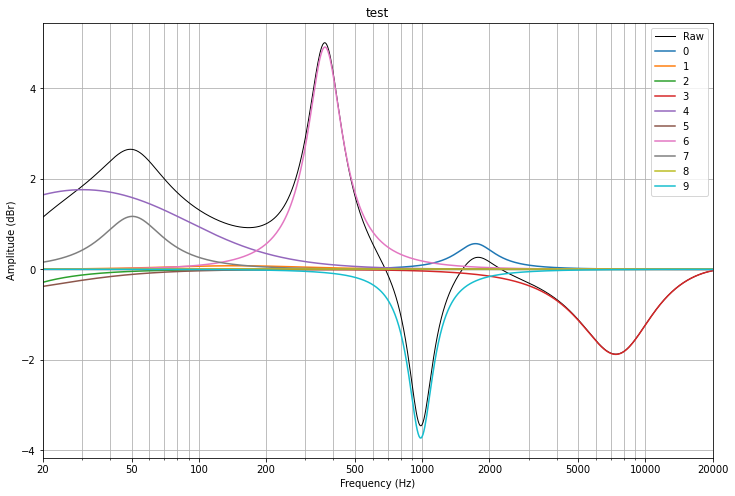

In [55]:
for i in range(1):
    filters = predict(test[i:i+1])
    print(filters)
    fr = FrequencyResponse(name='test', raw=tf.squeeze(peq_fr(filters)), target=y_test[i])
    fr.error = fr.raw - fr.target
    fig, ax = fr.plot_graph(show=False, raw=True, target=False, error=False)
    for i, filt in enumerate(filters[0]):
        ax.plot(fr.frequency, np.squeeze(peq_fr(np.expand_dims(np.expand_dims(filt, axis=0), axis=0))), label=i)
    ax.legend()

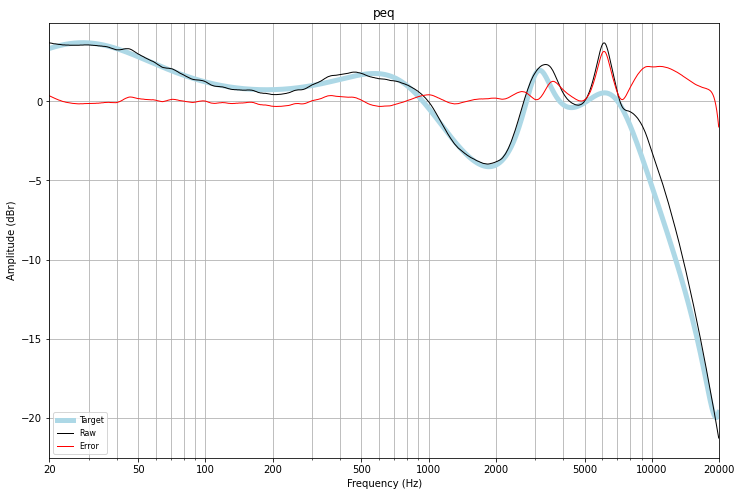

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'peq'}, xlabel='Frequency (Hz)', ylabel='Amplitude (dBr)'>)

In [29]:
p = np.array([
    [ 2.8177048e+01, 4.6592656e-01, 3.6886775e+00],
    [ 7.5532819e+02, 6.3449883e-01, 4.0352540e+00],
    [ 2.1447576e+03, 4.8449698e-01, -7.1967192e+00],
    [ 3.0843210e+03, 2.0635529e+00, 6.9372535e+00],
    [ 6.6201890e+03, 8.5014981e-01, 6.9353619e+00],
    [ 1.9410781e+04, 2.7364632e-01, -2.0113779e+01]], dtype='float32')
p = np.expand_dims(p, axis=0)
raw = peq_fr(p)
fr = FrequencyResponse(name='peq', raw=x_test[0], target=tf.squeeze(raw))
fr.error = fr.raw - fr.target
fr.plot_graph()